<a href="https://colab.research.google.com/github/PeanutButtermitKase/ReinforcementLearningModels/blob/main/dqn_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install gym and necessary packages
!pip install gym matplotlib
!pip install tqdm
!pip install numpy==1.23.5 --quiet
import os
os.kill(os.getpid(), 9)  # Automatically restarts the Colab runtime

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-8-8884f5e89ca4>:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(current_q, torch.tensor(target_q))
 50%|█████     | 100/200 [02:24<02:10,  1.30s/it]

Episode 100: Avg Reward (last 100): -200.00, Epsilon: 0.606


100%|██████████| 200/200 [04:43<00:00,  1.42s/it]

Episode 200: Avg Reward (last 100): -200.00, Epsilon: 0.367


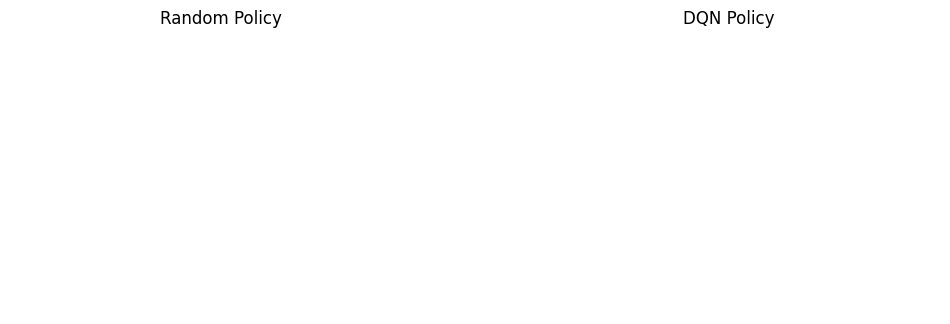

In [8]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import display
from tqdm import trange
import torch
import torch.nn as nn
import torch.optim as optim

rc('animation', html='jshtml')

# Create MountainCar environment
env = gym.make("MountainCar-v0", render_mode="rgb_array")
np.random.seed(0)
env.reset(seed=0)

######################################
# Define the Deep Q-Network (DQN)
######################################

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),  # hidden layer 1
            nn.ReLU(),
            nn.Linear(64, 64),         # hidden layer 2
            nn.ReLU(),
            nn.Linear(64, output_dim)  # output layer: one Q per action
        )

    def forward(self, x):
        return self.net(x)

######################################
# DQN Training Function
######################################

def train_dqn(env, num_episodes=200, gamma=0.99, epsilon=1.0,
              epsilon_decay=0.995, epsilon_min=0.05):
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    model = DQN(obs_dim, n_actions)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    rewards_per_episode = []

    for episode in trange(num_episodes):
        obs = env.reset()
        if isinstance(obs, tuple):  # backward compatibility
            obs = obs[0]
        obs = torch.FloatTensor(np.array(obs))
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_vals = model(obs)
                    action = torch.argmax(q_vals).item()

            # Take step in environment (old step API)
            result = env.step(action)
            if len(result) == 4:
                next_obs, reward, done, _ = result
            else:
                next_obs, reward, terminated, truncated, _ = result
                done = terminated or truncated

            next_obs_tensor = torch.FloatTensor(np.array(next_obs))

            # Compute target using Bellman equation
            with torch.no_grad():
                next_q = model(next_obs_tensor)
                max_next_q = torch.max(next_q)
                target_q = reward + gamma * max_next_q * (1 - int(done))

            # Current Q for action taken
            q_vals = model(obs)
            current_q = q_vals[action]

            # Loss and optimization
            loss = loss_fn(current_q, torch.tensor(target_q))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            obs = next_obs_tensor
            total_reward += reward

        # Epsilon decay and tracking
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        rewards_per_episode.append(total_reward)

        if (episode + 1) % 100 == 0:
            avg_r = np.mean(rewards_per_episode[-100:])
            print(f"Episode {episode+1}: Avg Reward (last 100): {avg_r:.2f}, Epsilon: {epsilon:.3f}")

    return model, rewards_per_episode

######################################
# Policies
######################################

def dqn_policy(obs, model):
    obs_tensor = torch.FloatTensor(np.array(obs))
    with torch.no_grad():
        q_vals = model(obs_tensor)
        return torch.argmax(q_vals).item()

def random_policy(_):
    return env.action_space.sample()

######################################
# Capture frames from a rollout
######################################

def capture_episode_frames(policy_fn, model=None):
    frames = []
    obs = env.reset()
    if isinstance(obs, tuple):
        obs = obs[0]
    done = False

    while not done:
        action = policy_fn(obs, model) if model else policy_fn(obs)
        result = env.step(action)

        if len(result) == 4:
            next_obs, reward, done, _ = result
        else:
            next_obs, reward, terminated, truncated, _ = result
            done = terminated or truncated

        frame = env.render()

        # ensure frame has shape (H, W, 3)
        if isinstance(frame, (tuple, list)) and hasattr(frame[0], 'shape'):
            frame = frame[0]  # extract first image if batched

        frames.append(frame)
        obs = next_obs

    return frames


######################################
# Train agent and visualize result
######################################

policy_net, rewards_dqn = train_dqn(env)

frames_random = capture_episode_frames(random_policy)
frames_dqn = capture_episode_frames(dqn_policy, model=policy_net)

# Side-by-side animation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("Random Policy")
ax2.set_title("DQN Policy")
ax1.axis('off')
ax2.axis('off')

ims = []
min_len = min(len(frames_random), len(frames_dqn))
for i in range(min_len):
    im1 = ax1.imshow(frames_random[i], animated=True)
    im2 = ax2.imshow(frames_dqn[i], animated=True)
    ims.append([im1, im2])

ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
display(ani)
